<a href="https://colab.research.google.com/github/mgnarag/binarization-autoencoder/blob/main/PA3_mini_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **[CS284 PA3] Mini GoogLeNet**
by **Mark Jeremy Narag**

This is my from scratch implementation of the mini GoogLeNet as described in Figure 3 of the paper by Zhang, et al. entitled *Understanding Deep Learning Requires Rethinking Generalization* (https://arxiv.org/abs/1611.03530)

I will use pytorch for this assignment.

PS Please ignore the commented print commands. I used those to debug my code 😎

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!ls drive/My\ Drive
file_path = "/content/drive/My Drive/CS284/"

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#!pip install torch
import torch
import torch.nn as nn
import cv2

In [ ]:
# checking our GPU:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

Tesla T4


**Opening the files of CIFAR10 which is in pickle:**

In [ ]:
#This is a function from the CIFAR website itself:
#I edited it so I can extract the data and label as one
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        data = dict[b'data']
        label = dict[b'labels']
    return data,label

data1,label1 = unpickle(file_path + 'cifar-10-batches-py/data_batch_1')
data2,label2 = unpickle(file_path + 'cifar-10-batches-py/data_batch_2')
data3,label3 = unpickle(file_path + 'cifar-10-batches-py/data_batch_3')
data4,label4 = unpickle(file_path + 'cifar-10-batches-py/data_batch_4')
data5,label5 = unpickle(file_path + 'cifar-10-batches-py/data_batch_5')
data_test,label_test = unpickle(file_path + 'cifar-10-batches-py/test_batch')

#print(label_test.count(9)) #checking here if the test dataset is balanced

## **Pre-processing stage**

Here are the exact steps from the paper:

Each image is of size 32x32, with 3 color channels. We divide the pixel values by 255 to scale them into [0, 1], crop from the center to get 28x28 inputs, and then normalize them by subtracting the mean and dividing the adjusted standard deviation independently for each image with the per_image_whitening function in TENSORFLOW (Abadi et al., 2015).

**Since the data is in 1D, we need to turn 1D vector into the 2D image first:**

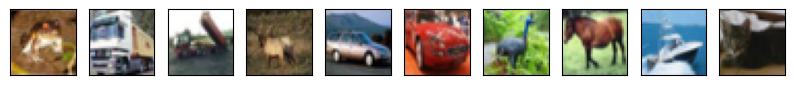

In [ ]:
def turn_to_image(data,i):
    #Each data consists of size 3072 which is actually 32 by 32 by 3
    r = np.array(data[i][0:1024]) #extracting the R channel on the first 32 by 32
    g = np.array(data[i][1024:2048]) #extracting the G channel
    b = np.array(data[i][2048:30724]) #extracting the B channel
    r = r.reshape((32, 32)) #Since it is 1D, we resize it to 2D
    g = g.reshape((32, 32))
    b = b.reshape((32, 32))
    rgb = np.stack((r,g,b), axis=-1)
    return rgb

#Let's visualize:
n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow((turn_to_image(data1,i)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### **We divide, crop, and whiten as mentioned:**

 Note that `tf.image.per_image_whitening` does not exist anymore on the latest version of tf so I will just write it.

In [ ]:
def divide_crop_norm(data):
    dataset = []
    for i in range(len(data)):
        image = turn_to_image(data,i)
        image = image/255 #dividing by 25
        #since it is from the center with size 28, we can just extract rows and columns from 2 to 30:
        image_crop = image[2:30, 2:30]
        mean = np.mean(image_crop)
        stddev = np.std(image_crop)
        adjusted_stddev = max(stddev, 1.0/len(image_crop.flatten()))
        final_image = (image_crop - mean) / adjusted_stddev
        dataset.append(final_image)
    return dataset

data_image1 = divide_crop_norm(data1)
data_image2 = divide_crop_norm(data2)
data_image3 = divide_crop_norm(data3)
data_image4 = divide_crop_norm(data4)
data_image5 = divide_crop_norm(data5)
data_image_test = divide_crop_norm(data_test)

Now prepping the training and testing data. Actually, we just need to merge the first 5 batches for our training.

In [ ]:
#Adding them together:
training_dataset = np.array(data_image1 + data_image2 + data_image3 + data_image4 + data_image5)
training_label = np.array(label1 + label2 + label3 + label4 + label5)
testing_dataset = np.array(data_image_test)
testing_label = np.array(label_test)

print(np.shape(training_dataset))
print(np.shape(training_label))

(50000, 28, 28, 3)
(50000,)


## **THE MODEL**

The model consists of three primary modules -> convolution, inception, and downsampling.

**Convolution module:**

In [ ]:
#the convolution operator requires these parameters:
# 1. in_channels = number of layers it will receive
# 2. out_channels = number of layers it will give which is the number of convolution filters it will generate
# 3. kernel_size = size of convolution filter
# 4. stride = how much will we move the window?
# 5. padding = the zeros we add on the boundaries so we will have same size after convolution operation. Here I already set it as 1.


class Conv_module(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(Conv_module, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding = 1)
        self.batch_norm = nn.BatchNorm2d(num_features=out_channels) #it takes in the number of channels it will receive which is the output of the convolution
        self.relu = nn.ReLU() #we use relu

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x) #this will take the previous layer
        x = self.relu(x) #this one too. Basically it is sequential

        return x

**Inception module:**

In [ ]:
# In inception, we basically have two convolution modules who will take in the output of the last layer
# The output of these two conv modules will be concatenated (merge) in the final step

class Inception_module(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels3):
        super(Inception_module, self).__init__()

        # this is the conv module with 1 by 1 filter. This is similar to Conv_module:
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride = 1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=out_channels1)
        self.relu1 = nn.ReLU(inplace=True)

        # this is the conv module with 3 by 3 filter
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels3, kernel_size=3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=out_channels3)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        #notice here how the first x1 and x3 takes in the same x input

        x1 = self.conv1(x)
        x1 = self.batch_norm1(x1)
        x1 = self.relu1(x1)

        x3 = self.conv3(x)
        x3 = self.batch_norm3(x3)
        x3 = self.relu3(x3)
        #print(x1.shape)
        #print(x3.shape)

        # concatenating the output of the two conv module
        output = torch.cat([x1, x3], dim=1)

        return output

**Down sample module**

In [ ]:
# In donwsample module, you have one conv module and one max pooling layer, both of which takes in same input from the previous layer.

class Downsample_module(nn.Module):
    def __init__(self,  in_channels3, out_channels3):
        super(Downsample_module, self).__init__()

        # conv module with 1 by 1 filter. This is similar to Conv_module:
        self.conv3 = nn.Conv2d(in_channels3, out_channels3, kernel_size=3, stride = 2, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(out_channels3)
        self.relu3 = nn.ReLU(inplace=True)

        # max pool with 3 by 3 filter and 2 by 2 strides
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)

    def forward(self, x):
        x3 = self.conv3(x)
        x3 = self.batch_norm3(x3)
        x3 = self.relu3(x3)
        #remember that x3 will have different number of layers compared to max_pooled. It will depend on out_channels3

        max_pooled = self.max_pool(x) #this will have the same layer as x

        #print(x3.shape)
        #print(max_pooled.shape)

        output = torch.cat([x3, max_pooled], dim=1)
        return output

**Fully connected**

In [ ]:
class Fully_connected(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,p):
        super(Fully_connected, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size) #the input size here is just 1D vector! remember that the output of the previous channel is still 2D
        self.dropout = nn.Dropout(p) #the dropout!
        self.relu = nn.ReLU() #I chose this as stated in the paper
        self.fc2 = nn.Linear(hidden_size, output_size) #then we have the output_size which is the number of classes, which is 10.

    def forward(self, x):
        x = torch.flatten(x, 1) #here we go. We need to flatten the 2D input first!
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


**Mini GoogLeNet model:**

In [ ]:
# Building the model. This is based on the paper

class miniGoogLeNet(nn.Module):
    def __init__(self, dropout_rate):
        super(miniGoogLeNet, self).__init__()
        self.Conv_1 = Conv_module(in_channels=3, out_channels=96, kernel_size=3, stride=1)
        self.Inception_2 = Inception_module(in_channels = 96, out_channels1 = 32, out_channels3 = 32)
        self.Inception_3 = Inception_module(in_channels = 64, out_channels1 = 32, out_channels3 = 48)
        self.DownSample_4 = Downsample_module(in_channels3 = 80, out_channels3=80)
        self.Inception_5 = Inception_module(in_channels = 160, out_channels1 = 112, out_channels3 = 48) #the calculation of  # of layers is in my report
        self.Inception_6 = Inception_module(in_channels = 160, out_channels1 = 96, out_channels3 = 64)
        self.Inception_7 = Inception_module(in_channels = 160, out_channels1 = 80, out_channels3 = 80)
        self.Inception_8 = Inception_module(in_channels = 160, out_channels1 = 48, out_channels3 = 96)
        self.DownSample_9 = Downsample_module(in_channels3 = 144, out_channels3=96)
        self.Inception_10 = Inception_module(in_channels = 240, out_channels1 = 176, out_channels3 = 160)
        self.Inception_11 = Inception_module(in_channels = 336, out_channels1 = 176, out_channels3 = 160)
        self.meanpool_12 = nn.AvgPool2d(kernel_size=7)

        self.fc13 = Fully_connected(input_size=336, hidden_size=512, output_size=10,p=dropout_rate)

    def forward(self, x):
        x = self.Conv_1(x)
        #print("done 1") #I was printing it to know which layer is faulty. This took me a lot of debugging actually
        x = self.Inception_2(x)
        #print("done 2")
        x = self.Inception_3(x)
        #print("done 3")
        x = self.DownSample_4(x)
        #print("done 4")
        x = self.Inception_5(x)
        #print("done 5")
        x = self.Inception_6(x)
        #print("done 6")
        x = self.Inception_7(x)
        #print("done 7")
        x = self.Inception_8(x)
        #print("done 8")
        x = self.DownSample_9(x)
        #print("done 9")
        x = self.Inception_10(x)
        #print("done 10")
        x = self.Inception_11(x)
        #print("done 11", x.shape) #I am trying to check the shape here so I know the length of the flattened layer
        x = self.meanpool_12(x)
        #print("done 12", x.shape)
        x = self.fc13(x)
        #print("done 13")

        return x

In [ ]:
#It's too long so I commented it out. I just used this to get the summary of the model which I used in the paper

#from torchsummary import summary

#model = miniGoogLeNet(dropout_rate).cuda()
#model_summary = summary(model, (3,28,28), device='cuda')
#print(model_summary)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import time


batch_size = 8 #this should be 16 pero it nauubos yung RAM so binabaan ko nalang

# The model actually wants (50000, 3, 28, 28) but I have (50000, 28, 28, 3), that is why I transpose the columns:
training_dataset_transpose = training_dataset.transpose(0, 3, 1, 2)
# This is still a numyy array so we convert it to pytorch tensors:
inputs_tensor = torch.tensor(training_dataset_transpose, dtype=torch.float32)
# 80-20 split of train and validation of the input data:
train_dataset = inputs_tensor[:40000]
val_dataset = inputs_tensor[40000:]

# For the labels. This took me a long time to edit. My loss calculation requires specific type of label
labels_tensor = torch.tensor(training_label).to(device) #converting it to pytorch tensor dirst
labels_tensor = torch.unsqueeze(labels_tensor, dim=1) #this is actually just making it into columns since it is in rows originally
labels_tensor = torch.round(labels_tensor).to(torch.int).to(torch.int64) #then it should be integer of int64
# Another 80-20 split of train and validation of the labels:
train_labels = labels_tensor[:40000]
val_labels = labels_tensor[40000:]

# Creating the TensorDataset in which I combine the input dataset and its correspong label
dataset = TensorDataset(train_dataset, train_labels)
val_dataset = TensorDataset(val_dataset, val_labels)
# Then we create dataloader from tensordataset
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #false kasi di naman to tinatrain

### **Then we train.....**

In [ ]:
# Defining the hyperparameters
learning_rate = 0.01
dropout_rate = 0.1
epochs = 80

model = miniGoogLeNet(dropout_rate)

# we move the model to the gpu para fasttt
model.to(device)

#then the linear decay
def linear_decay(epoch):
    decay_factor = 1.0 - (epoch / epochs)
    return decay_factor


optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = LambdaLR(optimizer, lr_lambda=linear_decay)


model.train() # setting the model in training mode

losses = []
val_accuracies = []

start_time = time.time() #recording the start time

for epoch in range(epochs):
  for batch in train_loader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        #print(batch[0].shape)
        #print(batch[1])
        # zero the gradients every batch run
        optimizer.zero_grad()

        # ---this it the forward pass
        outputs = model(inputs)
        #print("outputs=",outputs)
        #print("labels=",labels)
        #print(labels.dtype)

        loss = F.cross_entropy(outputs, labels.squeeze(dim=1))

        # ---this is the backward pass
        loss.backward()

        # update the weights using our optimizer
        optimizer.step()

  # Then for every epoch, we adjust the learning rate using the scheduler:
  scheduler.step()
  losses.append(loss.item()) #we will save this

  model.eval() #setting the model to validation mode
  correct = 0
  with torch.no_grad():
      for batch_val in val_loader:
        inputs_val, labels_val = batch_val[0].to(device), batch_val[1].to(device)
        outputs_val = model(inputs_val)
        _, predicted = torch.max(outputs_val, 1)
        correct += (predicted == labels).sum().item()

  # calculating the validation accuracy for each epoch:
  val_accuracy = correct / 10000
  val_accuracies.append(val_accuracy) #gonna save this for later

  print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.6f}, Validation Accuracy: {val_accuracy:.6f}')

end_time = time.time()
training_time = end_time - start_time #calculating training time
print(f"Training time: {training_time:.2f} seconds")

#saving the training time as text file:
training_text = str(training_time)
x = file_path + 'training_duration_'+ str(dropout_rate)+'.txt'
with open(x, 'w') as file:
    file.write(training_text)

# Saving the losses :
losses_df = pd.DataFrame(losses, columns=['loss'])
losses_df.to_csv(file_path + 'losses_'+str(dropout_rate)+'.csv', index=False)

# Saving the validatin accuracies:
val_accuracies_df = pd.DataFrame(val_accuracies)
val_accuracies_df.to_csv(file_path + 'val_accuracies_'+str(dropout_rate)+'.csv', index=False)

# Saving the trained model:
torch.save(model.state_dict(), file_path + 'model_'+str(dropout_rate)+'.pth')

Epoch [1/80], Training Loss: 1.579143, Validation Accuracy: 0.665200
Epoch [2/80], Training Loss: 0.885479, Validation Accuracy: 1.013900
Epoch [3/80], Training Loss: 1.010049, Validation Accuracy: 0.833300
Epoch [4/80], Training Loss: 1.628761, Validation Accuracy: 0.658400
Epoch [5/80], Training Loss: 0.559075, Validation Accuracy: 0.808500
Epoch [6/80], Training Loss: 0.848684, Validation Accuracy: 0.765300
Epoch [7/80], Training Loss: 1.211921, Validation Accuracy: 0.799200
Epoch [8/80], Training Loss: 0.660259, Validation Accuracy: 0.808600
Epoch [9/80], Training Loss: 1.047077, Validation Accuracy: 0.738200
Epoch [10/80], Training Loss: 0.399417, Validation Accuracy: 0.792400
Epoch [11/80], Training Loss: 0.891322, Validation Accuracy: 0.720700
Epoch [12/80], Training Loss: 0.064681, Validation Accuracy: 0.792900
Epoch [13/80], Training Loss: 0.098515, Validation Accuracy: 0.972900
Epoch [14/80], Training Loss: 0.414399, Validation Accuracy: 0.802600
Epoch [15/80], Training Loss:

## **Testing the model**

In [ ]:
# Loading the saved model:
loaded_model = miniGoogLeNet(dropout_rate)
loaded_model.load_state_dict(torch.load(file_path + 'model_'+str(dropout_rate)+'.pth'))
loaded_model.eval()  # Set the model to evaluation mode

#preparing the testing dataset:
testing_dataset_transpose = testing_dataset.transpose(0, 3, 1, 2)
inputs_tensor = torch.tensor(testing_dataset_transpose, dtype=torch.float32)
#for the labels:
labels_tensor = torch.tensor(testing_label).to(device)
labels_tensor = torch.unsqueeze(labels_tensor, dim=1)
labels_tensor = torch.round(labels_tensor).to(torch.int).to(torch.int64)

dataset = TensorDataset(inputs_tensor, labels_tensor)
test_loader = DataLoader(dataset, batch_size=8, shuffle=False)


Computing the predictions of the model:

In [ ]:
predictions, targets = [], []
for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

Computing for the accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(targets, predictions)
print(f"Accuracy: {accuracy:.4f}")
accuracy_str = str(accuracy)

# Specify the file path
file_path = file_path + 'accuracy_'+ str(dropout_rate)+'.txt'

# Write the training duration to a text file
with open(file_path, 'w') as file:
    file.write(accuracy_str)

Accuracy: 0.8437


Then for the confusion matrix:

Normalized confusion matrix
[[0.881 0.009 0.027 0.013 0.007 0.002 0.003 0.006 0.04  0.012]
 [0.005 0.932 0.001 0.004 0.001 0.    0.002 0.    0.013 0.042]
 [0.047 0.001 0.748 0.05  0.046 0.04  0.037 0.022 0.007 0.002]
 [0.017 0.003 0.04  0.721 0.035 0.099 0.052 0.019 0.007 0.007]
 [0.011 0.001 0.029 0.042 0.837 0.023 0.023 0.031 0.003 0.   ]
 [0.005 0.001 0.027 0.11  0.033 0.767 0.018 0.03  0.004 0.005]
 [0.009 0.001 0.033 0.047 0.022 0.01  0.869 0.004 0.003 0.002]
 [0.01  0.    0.015 0.036 0.029 0.027 0.005 0.873 0.001 0.004]
 [0.042 0.015 0.009 0.011 0.002 0.001 0.007 0.001 0.903 0.009]
 [0.017 0.044 0.001 0.008 0.002 0.    0.004 0.005 0.013 0.906]]


<Figure size 640x480 with 0 Axes>

<Figure size 20000x20000 with 0 Axes>

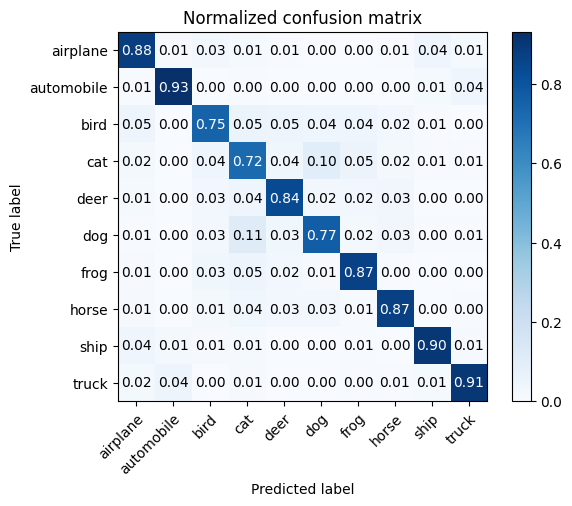

In [ ]:
from sklearn.metrics import confusion_matrix

classes = ("airplane", "automobile","bird", "cat","deer",
                               "dog", "frog","horse","ship", "truck")

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#    fig.tight_layout()
    return ax
plt.figure()
plt.figure(figsize=(200, 200))
plot_confusion_matrix(targets, predictions, classes=classes,  normalize=True,
                      title='Normalized confusion matrix')
plt.savefig(file_path + 'CM Normalized with dropout and validation_'+str(dropout_rate)+'.png')
plt.show()